In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
import itertools

# For reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [2]:
data = load_wine()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name="target")

print("Shape:", X.shape)
print("Classes:", data.target_names)
X.head()

Shape: (178, 13)
Classes: ['class_0' 'class_1' 'class_2']


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


In [3]:
# Missing values?
print("Missing values per column:\n", X.isnull().sum())

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Missing values per column:
 alcohol                         0
malic_acid                      0
ash                             0
alcalinity_of_ash               0
magnesium                       0
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 0
color_intensity                 0
hue                             0
od280/od315_of_diluted_wines    0
proline                         0
dtype: int64
Train shape: (124, 13) Test shape: (54, 13)


In [4]:
# (a) PCA with 2 components for visualization
pca_2 = PCA(n_components=2, random_state=RANDOM_STATE)
X_train_pca2 = pca_2.fit_transform(X_train)
X_test_pca2 = pca_2.transform(X_test)

print("Explained variance ratio (2 components):", pca_2.explained_variance_ratio_)
print("Total explained variance (2 components):", pca_2.explained_variance_ratio_.sum())

# (b) PCA to capture 95% variance
pca_95 = PCA(n_components=0.95, random_state=RANDOM_STATE)  
X_train_pca95 = pca_95.fit_transform(X_train)
X_test_pca95 = pca_95.transform(X_test)

print("Number of components to capture 95% variance:", pca_95.n_components_)
print("Explained variance ratio sum:", pca_95.explained_variance_ratio_.sum())

Explained variance ratio (2 components): [0.34976245 0.19717542]
Total explained variance (2 components): 0.5469378688053051
Number of components to capture 95% variance: 10
Explained variance ratio sum: 0.9652621960608675


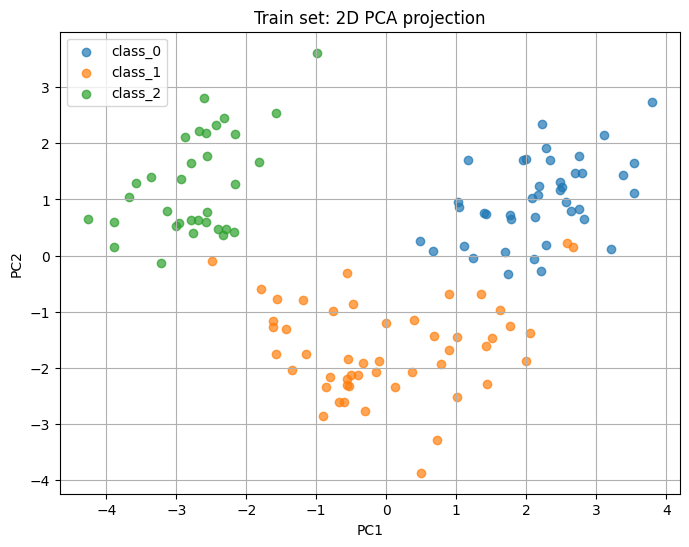

In [5]:
plt.figure(figsize=(8,6))
for label in np.unique(y_train):
    idx = np.where(y_train == label)
    plt.scatter(X_train_pca2[idx, 0], X_train_pca2[idx, 1], label=data.target_names[label], alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Train set: 2D PCA projection")
plt.legend()
plt.grid(True)
plt.show()

In [6]:
# SVM configurations to test
svm_configs = {
    "linear_orig": SVC(kernel="linear", C=1.0, probability=True, random_state=RANDOM_STATE),
    "rbf_orig": SVC(kernel="rbf", C=1.0, gamma="scale", probability=True, random_state=RANDOM_STATE),
    "rbf_pca95": SVC(kernel="rbf", C=1.0, gamma="scale", probability=True, random_state=RANDOM_STATE),
    "rbf_pca2": SVC(kernel="rbf", C=1.0, gamma="scale", probability=True, random_state=RANDOM_STATE),
}

In [7]:
results = []

# Helper to select the correct datasets
def get_data_for_key(key):
    if key.endswith("_orig"):
        return X_train, X_test
    elif key.endswith("_pca95"):
        return X_train_pca95, X_test_pca95
    elif key.endswith("_pca2"):
        return X_train_pca2, X_test_pca2
    else:
        raise ValueError(key)

for name, model in svm_configs.items():
    Xtr, Xte = get_data_for_key(name)
    t0 = time.time()
    model.fit(Xtr, y_train)
    train_time = time.time() - t0
    
    t0 = time.time()
    y_pred = model.predict(Xte)
    predict_time = time.time() - t0
    
    acc = accuracy_score(y_test, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="macro", zero_division=0)
    
    results.append({
        "model": name,
        "accuracy": acc,
        "precision_macro": prec,
        "recall_macro": rec,
        "f1_macro": f1,
        "train_time_s": train_time,
        "predict_time_s": predict_time,
        "n_features": Xtr.shape[1]
    })
    
    print(f"{name}: acc={acc:.4f}, precision={prec:.4f}, recall={rec:.4f}, f1={f1:.4f}, train_time={train_time:.4f}s, n_features={Xtr.shape[1]}")

linear_orig: acc=0.9630, precision=0.9666, recall=0.9619, f1=0.9636, train_time=0.0042s, n_features=13
rbf_orig: acc=0.9815, precision=0.9848, recall=0.9778, f1=0.9808, train_time=0.0045s, n_features=13
rbf_pca95: acc=0.9815, precision=0.9848, recall=0.9778, f1=0.9808, train_time=0.0029s, n_features=10
rbf_pca2: acc=0.9630, precision=0.9656, recall=0.9656, f1=0.9656, train_time=0.0021s, n_features=2



Model: linear_orig
              precision    recall  f1-score   support

     class_0       0.95      1.00      0.97        18
     class_1       0.95      0.95      0.95        21
     class_2       1.00      0.93      0.97        15

    accuracy                           0.96        54
   macro avg       0.97      0.96      0.96        54
weighted avg       0.96      0.96      0.96        54



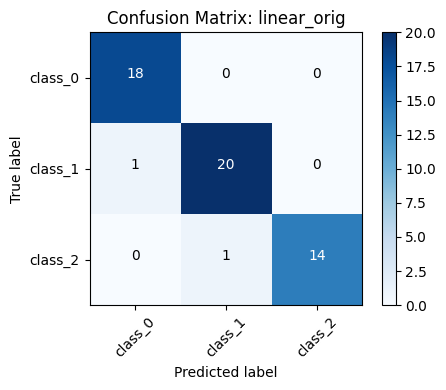


Model: rbf_orig
              precision    recall  f1-score   support

     class_0       1.00      1.00      1.00        18
     class_1       0.95      1.00      0.98        21
     class_2       1.00      0.93      0.97        15

    accuracy                           0.98        54
   macro avg       0.98      0.98      0.98        54
weighted avg       0.98      0.98      0.98        54



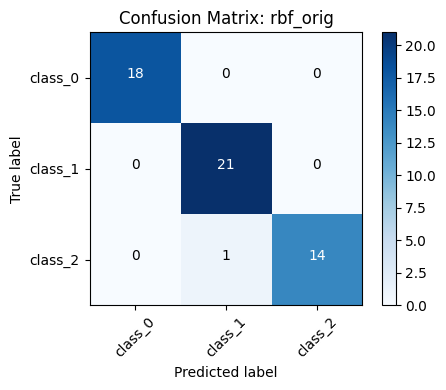


Model: rbf_pca95
              precision    recall  f1-score   support

     class_0       1.00      1.00      1.00        18
     class_1       0.95      1.00      0.98        21
     class_2       1.00      0.93      0.97        15

    accuracy                           0.98        54
   macro avg       0.98      0.98      0.98        54
weighted avg       0.98      0.98      0.98        54



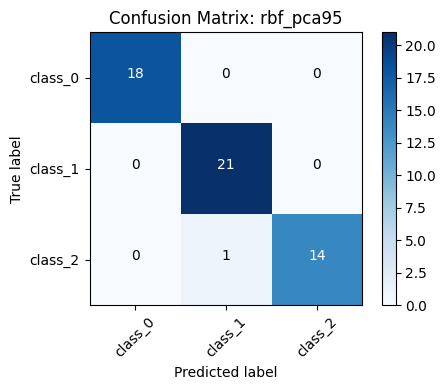


Model: rbf_pca2
              precision    recall  f1-score   support

     class_0       0.94      0.94      0.94        18
     class_1       0.95      0.95      0.95        21
     class_2       1.00      1.00      1.00        15

    accuracy                           0.96        54
   macro avg       0.97      0.97      0.97        54
weighted avg       0.96      0.96      0.96        54



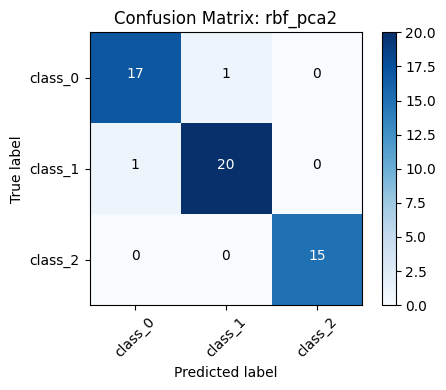

In [8]:
def plot_confusion(cm, classes, title="Confusion matrix"):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Show detailed results for each model
for name, model in svm_configs.items():
    Xtr, Xte = get_data_for_key(name)
    y_pred = model.predict(Xte)
    print("\n" + "="*60)
    print(f"Model: {name}")
    print(classification_report(y_test, y_pred, target_names=data.target_names, zero_division=0))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    plot_confusion(cm, data.target_names, title=f"Confusion Matrix: {name}")
    plt.show()

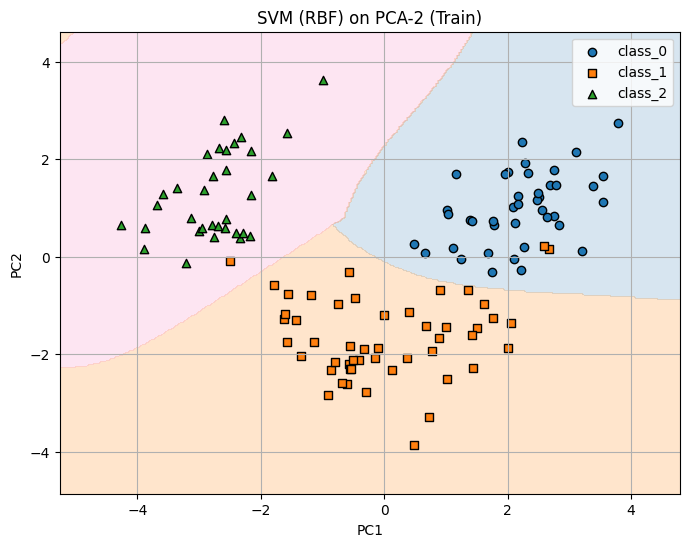

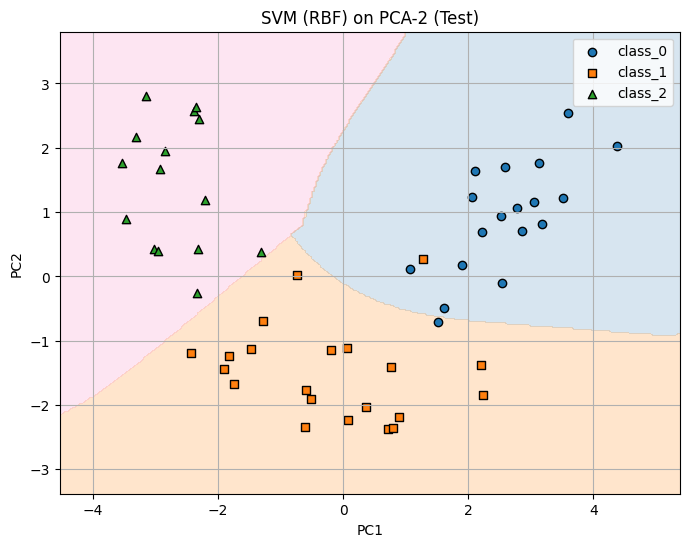

In [9]:
# Decision boundary helper
def plot_decision_boundary_2d(model, X2, y_true, title="Decision boundary (2D)"):
    # X2 assumed to be 2D (n_samples x 2)
    x_min, x_max = X2[:, 0].min() - 1.0, X2[:, 0].max() + 1.0
    y_min, y_max = X2[:, 1].min() - 1.0, X2[:, 1].max() + 1.0
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid)
    Z = Z.reshape(xx.shape)
    
    plt.figure(figsize=(8,6))
    plt.contourf(xx, yy, Z, alpha=0.2, levels=np.arange(-0.5, len(data.target_names)+0.5, 1), cmap=plt.cm.Set1)
    markers = ['o', 's', '^']
    for idx, label in enumerate(np.unique(y_true)):
        pts = X2[y_true==label]
        plt.scatter(pts[:,0], pts[:,1], marker=markers[idx], label=data.target_names[label], edgecolor='k')
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot train and test decision boundaries
plot_decision_boundary_2d(svm_configs["rbf_pca2"], X_train_pca2, y_train, title="SVM (RBF) on PCA-2 (Train)")
plot_decision_boundary_2d(svm_configs["rbf_pca2"], X_test_pca2, y_test, title="SVM (RBF) on PCA-2 (Test)")

In [10]:
results_df = pd.DataFrame(results)
results_df_sorted = results_df.sort_values(by="accuracy", ascending=False).reset_index(drop=True)
results_df_sorted

,model,accuracy,precision_macro,recall_macro,f1_macro,train_time_s,predict_time_s,n_features
0,rbf_orig,0.981481,0.984848,0.977778,0.980754,0.004500,0.000424,13
1,rbf_pca95,0.981481,0.984848,0.977778,0.980754,0.002854,0.000395,10
2,linear_orig,0.962963,0.966583,0.961905,0.963624,0.004238,0.000299,13
3,rbf_pca2,0.962963,0.965608,0.965608,0.965608,0.002140,0.000318,2


In [11]:
best = results_df_sorted.iloc[0]
print("Best model by accuracy:", best["model"])
print(f"Accuracy: {best['accuracy']:.4f}, F1(macro): {best['f1_macro']:.4f}, Train time: {best['train_time_s']:.4f}s, n_features: {best['n_features']}")
print("\nFull results:")
print(results_df_sorted.to_string(index=False))

Best model by accuracy: rbf_orig
Accuracy: 0.9815, F1(macro): 0.9808, Train time: 0.0045s, n_features: 13

Full results:
      model  accuracy  precision_macro  recall_macro  f1_macro  train_time_s  predict_time_s  n_features
   rbf_orig  0.981481         0.984848      0.977778  0.980754      0.004500        0.000424          13
  rbf_pca95  0.981481         0.984848      0.977778  0.980754      0.002854        0.000395          10
linear_orig  0.962963         0.966583      0.961905  0.963624      0.004238        0.000299          13
   rbf_pca2  0.962963         0.965608      0.965608  0.965608      0.002140        0.000318           2
